# Filtering

Before we start with segmentation, we will filter the TTS data so that we are including primarily post-secondary students. Specifically, we remove:
- School codes where over half of the students are under 19.  
- School zones where over half of the students are under 19.  
- Students whose indicated commute mode is school bus.

In [1]:
import pandas as pd

df = pd.read_csv('Original.csv')
original_df = df.copy()
print("Dataframe size:", df.shape[0])

print("Students who do not commute.")
df = df[df['SchoolCode'] != '9998'] # Outside study area, homeschooled, or distance education
print("Dataframe size:", df.shape[0])

grouped = df.groupby('SchoolCode')['Age'].quantile(0.5)
ps_codes = grouped[grouped > 19].index.tolist()
print("Removing students from school codes with over half of students under 19.")
df = df[df['SchoolCode'].isin(ps_codes)]
print("Dataframe size:", df.shape[0])

print("Removing school bus students.")
df = df[df['ModeTakenToSchool'] != 'S'] # School bus
print("Dataframe size:", df.shape[0])

Dataframe size: 19855
Students who do not commute.
Dataframe size: 18830
Removing students from school codes with over half of students under 19.
Dataframe size: 15175
Removing school bus students.
Dataframe size: 15149


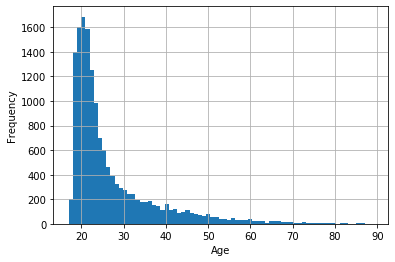

In [2]:
import matplotlib.pyplot as plt
df['Age'].hist(bins=len(df['Age'].unique()))
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

As we can see, the updated age distribution seems much more reasonable, with fewer 17-year-olds relative to 18-, 19-, and 20-year-olds.

Now let's load distances from the EMME LoS matrices:

In [3]:
LoS = pd.read_csv('../../../LoS/Walk_Distances.csv')
zones = LoS['Origin'].unique().tolist()
dists = LoS['Data'].tolist()

not_found = set()
def find_distance(o, d):
    try:
        i = zones.index(o)
    except ValueError:
        not_found.add(o)
        return -1
    try:
        j = zones.index(d)
    except ValueError:
        not_found.add(d)
        return -1
    return dists[i*2392 + j] / 1000

df['Dist'] = df.apply(lambda x: find_distance(x.HomeZone, x.SchoolZone), axis =1)

In [4]:
PD_df = pd.read_csv('../Zones.csv', index_col=0)

def zone_to_PD(x):
    try:
        return PD_df['PD'][x]
    except:
        return -1

df['PD'] = df['HomeZone'].apply(lambda x: zone_to_PD(x))

In [5]:
df.to_csv('Filtered.csv', index=True)